SumSquares synthetic function:

GP CBM versus GP dCBM (winner)

https://www.sfu.ca/~ssurjano/spheref.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
### Inputs:

obj_func = 'SumSquares'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'CBM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'SumSquares':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]

    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        f = (std + self.eps) * np.sqrt(Beta_CBM)
        #df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df = dsdx * np.sqrt(Beta_CBM)
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 10.90216133	 1.4334487	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 34.39648697	 1.4334487	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 47.93639038	 1.4334487	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 15.32343175	 1.4334487	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 1.4334487	 1.4334487	     	     	     	     	    
1  	 [ 4.04077223 -4.24914728]	 52.43834539	 1.4334487	 19.6 	 2.82842715 	 2.82842715 	 1.0 	 7.672
2  	 [5.12       1.53885091]	 30.95052422	 1.4334487	 15.3 	 2.82842715 	 2.82842715 	 1.0 	 11.131
3  	 [-3.65509812  5.12      ]	 65.78854229	 1.4334487	 33.0 	 2.82842632 	 2.82842712 	 1.0 	 9.933
4  	 [-0.13410844 -5.12      ]	 52.44678507	 1.4334487	 34.4 	 2.8284262 	 2.82842637 	 1.0 	 10.529
5  	 [ 2.27178108 -0.99371936]	 7.13594561	 1.4334487	 31.0 	 2.828426

In [15]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 47.56220442	 1.1358959	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959	 1.1358959	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 6.70185112	 1.1358959	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 12.13030006	 1.1358959	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 15.61091522	 1.1358959	     	     	     	     	    
1  	 [4.81874241 3.07464552]	 42.1271685	 1.1358959	 25.5 	 2.82842715 	 2.82842715 	 1.0 	 9.206
2  	 [ 4.84260546 -3.96517156]	 54.89599862	 1.1358959	 27.8 	 2.82842715 	 2.82842715 	 1.0 	 11.542
3  	 [0.50684745 3.5339583 ]	 25.23461692	 1.1358959	 30.0 	 2.82842714 	 2.82842714 	 1.0 	 8.154
4  	 [-3.07960242  4.80587866]	 55.6768905	 1.1358959	 40.8 	 2.82842607 	 2.82842604 	 1.0 	 10.009
5  	 [-5.12      -4.3234346]	 63.59857356	 1.1358959	 32.0 	 2.82842554 	 

In [16]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 9.35659664	 4.6090475	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 4.6090475	 4.6090475	     	     	     	     	    
init	 [4.02377681 4.05804123]	 49.1261771	 4.6090475	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 32.67360976	 4.6090475	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 21.83015893	 4.6090475	     	     	     	     	    
1  	 [ 2.87042319 -1.98283743]	 16.10261782	 4.6090475	 20.2 	 2.82842715 	 2.82842715 	 1.0 	 10.077
2  	 [-4.36609363  4.01810624]	 51.35312909	 4.6090475	 35.0 	 2.82842715 	 2.82842715 	 1.0 	 10.585
3  	 [-1.06170353 -5.12      ]	 53.55601438	 4.6090475	 40.4 	 2.82842401 	 2.82842535 	 1.0 	 11.687
4  	 [ 4.37118552 -5.12      ]	 71.53606287	 4.6090475	 42.8 	 2.82842406 	 2.82842518 	 1.0 	 10.81
5  	 [5.12       0.67853962]	 27.13523203	 4.6090475	 41.6 	 2.82842409 

In [17]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 23.33906213	 7.28991025	     	     	     	     	    
init	 [4.84028785 2.19971578]	 33.10588542	 7.28991025	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 21.00371518	 7.28991025	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 74.91598187	 7.28991025	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 7.28991025	 7.28991025	     	     	     	     	    
1  	 [-0.85221064  4.14379611]	 35.06835536	 7.28991025	 23.6 	 2.82842715 	 2.82842715 	 1.0 	 7.321
2  	 [-4.62301044 -3.99546247]	 53.29966626	 7.28991025	 33.0 	 2.82842708 	 2.82842708 	 1.0 	 9.698
3  	 [-1.00715827 -5.12      ]	 53.44316778	 7.28991025	 36.2 	 2.8284261 	 2.82842667 	 1.0 	 11.895
4  	 [-5.12        2.30859273]	 36.87360076	 7.28991025	 35.7 	 2.82842171 	 2.82842709 	 1.0 	 10.754
5	 [1.25221775 0.9916883 ]	 3.53494066	 3.53494066	 37.5 	 2.8

In [18]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 36.92798228	 2.63273131	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 45.76864773	 2.63273131	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 2.63273131	 2.63273131	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 7.48530515	 2.63273131	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 24.78058748	 2.63273131	     	     	     	     	    
1  	 [ 4.32895605 -5.09732646]	 70.70533461	 2.63273131	 24.0 	 2.82842715 	 2.82842715 	 1.0 	 7.37
2  	 [4.02415917 4.76321328]	 61.57025859	 2.63273131	 31.0 	 2.82842715 	 2.82842715 	 1.0 	 8.616
3  	 [-4.50499295  0.59896212]	 21.01247276	 2.63273131	 34.4 	 2.82842601 	 2.82842629 	 1.0 	 10.345
4  	 [-5.08995628 -5.12      ]	 78.33645491	 2.63273131	 35.8 	 2.8284262 	 2.82842613 	 1.0 	 10.013
5  	 [0.55353466 4.92885023]	 48.89352986	 2.63273131	 38.1 	 2.

In [19]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 22.10405236	 1.47571788	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 54.86905815	 1.47571788	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 18.03582918	 1.47571788	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 1.47571788	 1.47571788	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 5.98869002	 1.47571788	     	     	     	     	    
1  	 [4.87990293 3.44994399]	 47.61767968	 1.47571788	 26.4 	 2.82842715 	 2.82842715 	 1.0 	 9.977
2  	 [-2.54347117 -4.69631487]	 50.57999227	 1.47571788	 35.1 	 2.82842715 	 2.82842715 	 1.0 	 13.292
3  	 [-1.10963196  5.12      ]	 53.66008308	 1.47571788	 32.7 	 2.82842705 	 2.82842707 	 1.0 	 9.926
4  	 [-5.12        4.35890853]	 64.21456717	 1.47571788	 37.6 	 2.82842362 	 2.82842603 	 1.0 	 9.585
5  	 [-5.12       -2.37655667]	 37.51044322	 1.47571788	 36.8

In [20]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 35.25561299	 5.62252046	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 10.87025124	 5.62252046	     	     	     	     	    
init	 [4.8946126  0.39419771]	 24.26801621	 5.62252046	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 38.40742212	 5.62252046	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.62252046	 5.62252046	     	     	     	     	    
1  	 [-5.10538874 -4.17523358]	 60.93014509	 5.62252046	 32.4 	 2.82842715 	 2.82842715 	 1.0 	 7.91
2  	 [3.63690937 5.12      ]	 65.6559098	 5.62252046	 30.6 	 2.82842715 	 2.82842715 	 1.0 	 9.092
3  	 [ 3.81570236 -4.87523301]	 62.09537831	 5.62252046	 35.6 	 2.82842701 	 2.82842701 	 1.0 	 9.631
4  	 [-4.02558214 -1.33646422]	 19.7775848	 5.62252046	 3.2 	 2.82842715 	 2.82842715 	 1.0 	 3.08
5	 [ 1.30700083 -0.77550987]	 2.9110823	 2.9110823	 34.8 	 2

In [21]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 60.6611937	 0.15183063	     	     	     	     	    
init	 [3.78055209 0.31596228]	 14.49223845	 0.15183063	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 57.55595953	 0.15183063	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 2.50663131	 0.15183063	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 0.15183063	 0.15183063	     	     	     	     	    
1  	 [ 4.96383424 -4.82578382]	 71.21602927	 0.15183063	 25.6 	 2.82842715 	 2.82842715 	 1.0 	 7.382
2  	 [-5.03492225  2.95509263]	 42.81558691	 0.15183063	 22.0 	 2.82842715 	 2.82842715 	 1.0 	 5.177
3  	 [-2.03342217  4.86918874]	 51.55280375	 0.15183063	 30.0 	 2.82842715 	 2.82842715 	 1.0 	 14.48
4  	 [ 0.86581709 -4.92345847]	 49.23052577	 0.15183063	 34.5 	 2.82842447 	 2.82842632 	 1.0 	 9.017
5  	 [-4.48426704 -0.98858546]	 22.06325329	 0.15183063	 33.3 	 2

In [22]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.13861318	 14.00341365	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 28.12065798	 14.00341365	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 30.04200788	 14.00341365	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 14.00341365	 14.00341365	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 23.14707552	 14.00341365	     	     	     	     	    
1  	 [3.11029524 4.9495987 ]	 58.67099113	 14.00341365	 14.1 	 2.82842715 	 2.82842715 	 1.0 	 11.143
2  	 [-2.02106223  4.82097351]	 50.5682638	 14.00341365	 21.8 	 2.82842715 	 2.82842715 	 1.0 	 6.377
3	 [2.0867143  0.36749559]	 4.62448257	 4.62448257	 23.8 	 2.82842714 	 2.82842714 	 1.0 	 7.45
4  	 [ 4.43889093 -3.24498238]	 40.76357399	 4.62448257	 33.2 	 2.82842715 	 2.82842715 	 1.0 	 7.879
5  	 [-1.58041924  1.17954446]	 5.28037522	 4.62448257	 37.

In [23]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 55.8861941	 14.85502883	     	     	     	     	    
init	 [1.36855793 2.54775176]	 14.85502883	 14.85502883	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 15.88340999	 14.85502883	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 23.79413325	 14.85502883	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 47.01981043	 14.85502883	     	     	     	     	    
1  	 [4.54922969 4.99328486]	 70.56127825	 14.85502883	 29.2 	 2.82842712 	 2.82842712 	 1.0 	 7.088
2  	 [ 4.88530663 -0.60647603]	 24.60184726	 14.85502883	 30.8 	 2.82842715 	 2.82842715 	 1.0 	 7.589
3  	 [-5.12       -1.10049737]	 28.63658891	 14.85502883	 45.6 	 2.82842403 	 2.82842607 	 1.0 	 9.972
4  	 [-0.79278055  5.12      ]	 53.05730099	 14.85502883	 36.9 	 2.82841835 	 2.82841834 	 1.0 	 10.506
5  	 [-5.12  5.12]	 78.6432	 14.85502883	 38.8 	 2.82

In [24]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 59.14341502	 0.71221417	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 10.75245711	 0.71221417	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 0.71221417	 0.71221417	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 24.92480747	 0.71221417	     	     	     	     	    
init	 [4.52410012 3.59214172]	 46.2744461	 0.71221417	     	     	     	     	    
1  	 [ 3.03550212 -4.46785095]	 49.13765733	 0.71221417	 30.6 	 2.82842715 	 2.82842715 	 1.0 	 8.676
2  	 [5.02497284 0.07913932]	 25.26287807	 0.71221417	 35.6 	 2.82842591 	 2.82842595 	 1.0 	 8.621
3  	 [-3.90183987  3.35466039]	 37.73184705	 0.71221417	 41.6 	 2.82840045 	 2.8284261 	 1.0 	 9.171
4  	 [1.44618863 5.12      ]	 54.52026156	 0.71221417	 36.9 	 2.8284033 	 2.82841995 	 1.0 	 6.106
5  	 [-0.20435345 -3.53113634]	 24.97960809	 0.71221417	 44.2 	 2.82

In [25]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 24.62591779	 6.1128285	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 6.1128285	 6.1128285	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 61.48174178	 6.1128285	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 62.49130468	 6.1128285	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 49.49665109	 6.1128285	     	     	     	     	    
1  	 [4.61121049 2.73895066]	 36.26696367	 6.1128285	 22.8 	 2.82842715 	 2.82842715 	 1.0 	 6.79
2  	 [-1.92221187 -4.40449357]	 42.49402571	 6.1128285	 24.0 	 2.82842715 	 2.82842715 	 1.0 	 7.131
3  	 [0.76219182 2.84343759]	 16.75121102	 6.1128285	 28.0 	 2.82842699 	 2.82842699 	 1.0 	 7.848
4  	 [ 2.47156837 -0.37978654]	 6.39712584	 6.1128285	 32.1 	 2.82842555 	 2.82842631 	 1.0 	 8.515
5  	 [-4.94221639 -2.26667105]	 34.70109813	 6.1128285	 37.5 	 2.82842588 	

In [26]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 22.53262435	 12.4401513	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.51837199	 12.4401513	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 23.87458214	 12.4401513	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.16728409	 12.4401513	     	     	     	     	    
init	 [1.45012065 2.27346667]	 12.4401513	 12.4401513	     	     	     	     	    
1  	 [-4.10876704 -2.60547476]	 30.45896402	 12.4401513	 17.2 	 2.82842715 	 2.82842715 	 1.0 	 6.836
2  	 [-3.79946932  2.66821301]	 28.67468842	 12.4401513	 32.2 	 2.82842715 	 2.82842715 	 1.0 	 11.977
3	 [-0.80178199 -0.61076847]	 1.38893059	 1.38893059	 33.9 	 2.82842587 	 2.82842648 	 1.0 	 10.527
4  	 [ 0.16294114 -5.12      ]	 52.45534981	 1.38893059	 34.4 	 2.82842095 	 2.82842643 	 1.0 	 10.008
5  	 [ 5.12 -5.12]	 78.6432	 1.38893059	 32.8 	 2.82839692 	 2.82

In [27]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 15.66915514	 6.94295185	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 65.14302308	 6.94295185	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 47.71049978	 6.94295185	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 6.94295185	 6.94295185	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 16.45574874	 6.94295185	     	     	     	     	    
1  	 [-4.59142601 -1.8849894 ]	 28.18756282	 6.94295185	 24.3 	 2.82842715 	 2.82842715 	 1.0 	 9.284
2  	 [4.45447136 5.0693151 ]	 71.23822627	 6.94295185	 27.0 	 2.82842715 	 2.82842715 	 1.0 	 7.201
3  	 [ 5.12       -0.99120294]	 28.17936653	 6.94295185	 32.4 	 2.82842714 	 2.82842715 	 1.0 	 10.687
4  	 [-5.12        1.64320834]	 31.61466731	 6.94295185	 38.8 	 2.82842553 	 2.8284261 	 1.0 	 8.323
5  	 [-2.32182591 -5.12      ]	 57.81967553	 6.94295185	 39.6 	

In [28]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 34.38169974	 5.47826118	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 24.84447201	 5.47826118	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 5.47826118	 5.47826118	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 11.96719024	 5.47826118	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 28.92453308	 5.47826118	     	     	     	     	    
1  	 [2.7754098  2.98802689]	 25.559509	 5.47826118	 29.0 	 2.82842715 	 2.82842715 	 1.0 	 7.64
2  	 [-4.96635744  4.09320867]	 58.17342058	 5.47826118	 31.2 	 2.82842715 	 2.82842715 	 1.0 	 10.574
3  	 [-1.52549549  5.12      ]	 54.7559365	 5.47826118	 36.2 	 2.82842583 	 2.82842626 	 1.0 	 9.793
4  	 [ 0.27547173 -4.86608022]	 47.43335818	 5.47826118	 33.6 	 2.82842537 	 2.82842601 	 1.0 	 8.805
5  	 [5.12       0.27452861]	 26.36513192	 5.47826118	 37.6 	 2.

In [29]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 8.14123924	 8.14123924	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 43.5710395	 8.14123924	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 18.11570093	 8.14123924	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 27.44864454	 8.14123924	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 60.14651626	 8.14123924	     	     	     	     	    
1  	 [2.142749   4.83374619]	 51.32157765	 8.14123924	 28.5 	 2.82842715 	 2.82842715 	 1.0 	 7.227
2  	 [4.72424646 1.54809781]	 27.1117183	 8.14123924	 31.8 	 2.82842715 	 2.82842714 	 1.0 	 13.405
3	 [1.02167117 0.06318095]	 1.05179564	 1.05179564	 33.4 	 2.8284256 	 2.82842608 	 1.0 	 12.35
4  	 [-5.1050856  -2.62834329]	 39.87827585	 1.05179564	 37.2 	 2.82842604 	 2.82842615 	 1.0 	 9.658
5  	 [ 5.05776336 -5.12      ]	 78.00977025	 1.05179564	 36.3 	 2.8284

In [30]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 4.61725346	 3.18175623	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 49.13413497	 3.18175623	     	     	     	     	    
init	 [2.93873111 1.60085526]	 13.76161569	 3.18175623	     	     	     	     	    
init	 [1.40821398 0.77417363]	 3.18175623	 3.18175623	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 26.5181659	 3.18175623	     	     	     	     	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856	 3.18175623	 28.4 	 2.82842715 	 2.82842715 	 1.0 	 10.825
2  	 [-1.95646705  4.77829278]	 49.49192711	 3.18175623	 24.8 	 2.82842715 	 2.82842715 	 1.0 	 8.432
3  	 [ 0.85060064 -3.51017429]	 25.36616848	 3.18175623	 33.0 	 2.82842713 	 2.82842713 	 1.0 	 9.024
4  	 [-4.98471421  2.75299081]	 40.00529259	 3.18175623	 35.6 	 2.82842613 	 2.82842631 	 1.0 	 8.474
5  	 [3.92862014 5.04095826]	 66.25657658	 3.18175623	 38.0 	 2.

In [31]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 2.37732009	 2.37732009	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 36.25874706	 2.37732009	     	     	     	     	    
init	 [3.60686662 2.56139557]	 26.13098137	 2.37732009	     	     	     	     	    
init	 [1.70088108 4.99604939]	 52.81401545	 2.37732009	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 52.8539921	 2.37732009	     	     	     	     	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666	 2.37732009	 24.2 	 2.82842715 	 2.82842715 	 1.0 	 9.393
2  	 [-3.10840374 -1.1627454 ]	 12.36612755	 2.37732009	 31.5 	 2.8284268 	 2.8284268 	 1.0 	 8.915
3  	 [-1.42282695  2.87154428]	 18.51596968	 2.37732009	 36.4 	 2.82842544 	 2.82842598 	 1.0 	 9.503
4  	 [ 1.03023023 -5.12      ]	 53.49017433	 2.37732009	 31.2 	 2.82842267 	 2.82842245 	 1.0 	 7.353
5  	 [ 5.12       -0.27349427]	 26.36399824	 2.37732009	 38.2 	 2.82

In [32]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 31.29810938	 22.81445845	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 34.17704923	 22.81445845	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 39.44627428	 22.81445845	     	     	     	     	    
init	 [1.76104531 3.13952049]	 22.81445845	 22.81445845	     	     	     	     	    
init	 [4.9432772  1.38916592]	 28.29555346	 22.81445845	     	     	     	     	    
1  	 [ 4.82682643 -3.73084389]	 51.13664559	 22.81445845	 20.4 	 2.82842715 	 2.82842715 	 1.0 	 6.927
2	 [ 0.91885627 -1.50237801]	 5.35857621	 5.35857621	 33.2 	 2.82842676 	 2.828427 	 1.0 	 8.993
3  	 [5.12 5.12]	 78.6432	 5.35857621	 37.8 	 2.82842676 	 2.82842676 	 1.0 	 10.386
4  	 [-4.94044862 -0.9051206 ]	 26.04651915	 5.35857621	 34.8 	 2.82842606 	 2.82842606 	 1.0 	 8.163
5  	 [-1.15682247  5.12      ]	 53.76703823	 5.35857621	 39.0 	 2.82842185 	 2

In [33]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 33.98638836	 1.61518705	     	     	     	     	    
init	 [4.00927467 3.23417577]	 36.99406917	 1.61518705	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 30.29759868	 1.61518705	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 1.61518705	 1.61518705	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 22.27217825	 1.61518705	     	     	     	     	    
1  	 [-2.67107132  5.12      ]	 59.56342199	 1.61518705	 38.1 	 2.82842591 	 2.8284266 	 1.0 	 11.527
2  	 [-4.75610085 -3.8764158 ]	 52.67369413	 1.61518705	 28.6 	 2.82842715 	 2.82842715 	 1.0 	 8.623
3  	 [ 5.12 -5.12]	 78.6432	 1.61518705	 33.8 	 2.82842582 	 2.82842712 	 1.0 	 15.878
4  	 [ 5.12       -0.15948081]	 26.26526826	 1.61518705	 35.2 	 2.82842568 	 2.82842613 	 1.0 	 9.657
5  	 [-1.44394023 -5.12      ]	 54.51376339	 1.61518705	 43.4 	 2.82842494 	 2

In [34]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 10.90216133	 1.4334487	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 34.39648697	 1.4334487	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 47.93639038	 1.4334487	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 15.32343175	 1.4334487	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 1.4334487	 1.4334487	     	     	     	     	    
1  	 [ 4.04077223 -4.24914728]	 52.43834539	 1.4334487	 4.5 	 2.82842715 	 2.82842715 	 1.0 	 5.864
2  	 [5.12 5.12]	 78.6432	 1.4334487	 4.7 	 2.82842715 	 2.82842715 	 1.0 	 14.496
3  	 [4.78490962 0.69734873]	 23.86795057	 1.4334487	 7.6 	 2.82842715 	 2.82842715 	 1.0 	 8.47
4  	 [-4.89958599  4.58721496]	 66.09102514	 1.4334487	 11.8 	 2.82842715 	 2.82842715 	 1.0 	 9.592
5  	 [ 0.5934114 -5.12     ]	 52.78093709	 1.4334487	 11.9 	 2.82842601 	 2.82842619 	 1.0 	

In [35]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 47.56220442	 1.1358959	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959	 1.1358959	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 6.70185112	 1.1358959	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 12.13030006	 1.1358959	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 15.61091522	 1.1358959	     	     	     	     	    
1  	 [4.81874241 3.07464552]	 42.1271685	 1.1358959	 7.0 	 2.82842715 	 2.82842715 	 1.0 	 9.02
2  	 [ 4.84260546 -3.96517156]	 54.89599862	 1.1358959	 9.6 	 2.82842715 	 2.82842715 	 1.0 	 6.92
3  	 [0.50684745 3.5339583 ]	 25.23461692	 1.1358959	 12.5 	 2.82842714 	 2.82842714 	 1.0 	 11.574
4  	 [-4.40363105 -5.12      ]	 71.82076646	 1.1358959	 13.8 	 2.82842607 	 2.82842604 	 1.0 	 8.409
5  	 [ 4.85858539 -0.35830455]	 23.86261629	 1.1358959	 16.4 	 2.82842367 	 2.

In [36]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 9.35659664	 4.6090475	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 4.6090475	 4.6090475	     	     	     	     	    
init	 [4.02377681 4.05804123]	 49.1261771	 4.6090475	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 32.67360976	 4.6090475	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 21.83015893	 4.6090475	     	     	     	     	    
1  	 [ 2.87042319 -1.98283743]	 16.10261782	 4.6090475	 6.4 	 2.82842715 	 2.82842715 	 1.0 	 4.687
2  	 [-4.36609363  4.01810624]	 51.35312909	 4.6090475	 8.1 	 2.82842715 	 2.82842715 	 1.0 	 8.431
3  	 [5.12      0.6509897]	 27.06197518	 4.6090475	 15.0 	 2.82842401 	 2.82842535 	 1.0 	 9.019
4  	 [-0.21590577 -4.48225812]	 40.22789102	 4.6090475	 8.1 	 2.82842702 	 2.82842702 	 1.0 	 7.879
5  	 [ 2.89275183 -5.12      ]	 60.79681317	 4.6090475	 11.0 	 2.82839341 	 2.8284

In [37]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 23.33906213	 7.28991025	     	     	     	     	    
init	 [4.84028785 2.19971578]	 33.10588542	 7.28991025	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 21.00371518	 7.28991025	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 74.91598187	 7.28991025	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 7.28991025	 7.28991025	     	     	     	     	    
1  	 [-0.85221064  4.14379611]	 35.06835536	 7.28991025	 6.8 	 2.82842715 	 2.82842715 	 1.0 	 6.736
2  	 [-4.62301044 -3.99546247]	 53.29966626	 7.28991025	 9.8 	 2.82842708 	 2.82842708 	 1.0 	 9.225
3	 [1.12228096 0.68518006]	 2.19845798	 2.19845798	 14.9 	 2.8284261 	 2.82842667 	 1.0 	 10.72
4  	 [-3.39303942  2.26638176]	 21.78568906	 2.19845798	 13.4 	 2.82838019 	 2.82842715 	 1.0 	 11.026
5  	 [-0.75839739 -5.12      ]	 53.0039666	 2.19845798	 16.0 	 2.82842

In [38]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 36.92798228	 2.63273131	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 45.76864773	 2.63273131	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 2.63273131	 2.63273131	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 7.48530515	 2.63273131	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 24.78058748	 2.63273131	     	     	     	     	    
1  	 [ 4.32895605 -5.09732646]	 70.70533461	 2.63273131	 7.4 	 2.82842715 	 2.82842715 	 1.0 	 7.703
2  	 [4.02415917 4.76321328]	 61.57025859	 2.63273131	 10.0 	 2.82842715 	 2.82842715 	 1.0 	 9.096
3  	 [-4.3039995  0.5439134]	 19.11609525	 2.63273131	 16.4 	 2.82842601 	 2.82842629 	 1.0 	 9.112
4  	 [-5.12 -5.12]	 78.6432	 2.63273131	 11.4 	 2.8284263 	 2.8284263 	 1.0 	 9.022
5  	 [ 1.5895306  -3.21415873]	 23.18824028	 2.63273131	 14.8 	 2.82842012 	 2.828423

In [39]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 22.10405236	 1.47571788	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 54.86905815	 1.47571788	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 18.03582918	 1.47571788	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 1.47571788	 1.47571788	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 5.98869002	 1.47571788	     	     	     	     	    
1  	 [4.87990293 3.44994399]	 47.61767968	 1.47571788	 8.6 	 2.82842715 	 2.82842715 	 1.0 	 8.299
2  	 [-2.54347117 -4.69631487]	 50.57999227	 1.47571788	 11.4 	 2.82842715 	 2.82842715 	 1.0 	 9.861
3  	 [1.2610555  4.84426245]	 48.52401834	 1.47571788	 9.2 	 2.82842705 	 2.82842707 	 1.0 	 5.645
4  	 [-5.12       -2.36849369]	 37.4339247	 1.47571788	 11.9 	 2.82842362 	 2.82842631 	 1.0 	 6.637
5  	 [-2.95917994  4.41150563]	 47.67950972	 1.47571788	 7.8 	 2.82

In [40]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 35.25561299	 5.62252046	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 10.87025124	 5.62252046	     	     	     	     	    
init	 [4.8946126  0.39419771]	 24.26801621	 5.62252046	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 38.40742212	 5.62252046	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.62252046	 5.62252046	     	     	     	     	    
1  	 [-5.10538874 -4.17523358]	 60.93014509	 5.62252046	 6.8 	 2.82842715 	 2.82842715 	 1.0 	 12.329
2  	 [5.12 5.12]	 78.6432	 5.62252046	 14.6 	 2.82842715 	 2.82842715 	 1.0 	 10.095
3  	 [ 3.81570236 -4.87523301]	 62.09537831	 5.62252046	 17.8 	 2.82842701 	 2.82842701 	 1.0 	 10.511
4  	 [-4.02558214 -1.33646422]	 19.7775848	 5.62252046	 1.4 	 2.82842715 	 2.82842715 	 1.0 	 0.143
5  	 [1.48149942 5.12      ]	 54.62364053	 5.62252046	 15.6 	 2.8284251

In [41]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 60.6611937	 0.15183063	     	     	     	     	    
init	 [3.78055209 0.31596228]	 14.49223845	 0.15183063	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 57.55595953	 0.15183063	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 2.50663131	 0.15183063	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 0.15183063	 0.15183063	     	     	     	     	    
1  	 [ 4.96383424 -4.82578382]	 71.21602927	 0.15183063	 6.3 	 2.82842715 	 2.82842715 	 1.0 	 6.355
2  	 [-5.03492225  2.95509263]	 42.81558691	 0.15183063	 7.2 	 2.82842715 	 2.82842715 	 1.0 	 4.362
3  	 [-2.03342217  4.86918874]	 51.55280375	 0.15183063	 8.2 	 2.82842715 	 2.82842715 	 1.0 	 7.474
4  	 [-4.1300006  -1.50838561]	 21.60735928	 0.15183063	 11.8 	 2.82842447 	 2.82842632 	 1.0 	 7.376
5  	 [0.86761442 3.13188671]	 20.37018352	 0.15183063	 18.9 	 2.8284

In [42]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.13861318	 14.00341365	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 28.12065798	 14.00341365	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 30.04200788	 14.00341365	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 14.00341365	 14.00341365	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 23.14707552	 14.00341365	     	     	     	     	    
1  	 [3.11029524 4.9495987 ]	 58.67099113	 14.00341365	 5.1 	 2.82842715 	 2.82842715 	 1.0 	 6.466
2  	 [5.12       0.05445221]	 26.22033009	 14.00341365	 8.3 	 2.82842715 	 2.82842715 	 1.0 	 9.251
3  	 [-2.22549747  3.7025257 ]	 32.37023206	 14.00341365	 8.0 	 2.82842715 	 2.82842715 	 1.0 	 7.654
4	 [1.43399434 1.8251197 ]	 8.71846359	 8.71846359	 11.6 	 2.82842589 	 2.82842711 	 1.0 	 7.304
5  	 [ 3.36618299 -2.87354512]	 27.84571105	 8.71846359	 13.2 

In [43]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 55.8861941	 14.85502883	     	     	     	     	    
init	 [1.36855793 2.54775176]	 14.85502883	 14.85502883	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 15.88340999	 14.85502883	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 23.79413325	 14.85502883	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 47.01981043	 14.85502883	     	     	     	     	    
1  	 [4.54922969 4.99328486]	 70.56127825	 14.85502883	 8.9 	 2.82842712 	 2.82842712 	 1.0 	 8.605
2  	 [ 4.88530663 -0.60647603]	 24.60184726	 14.85502883	 9.6 	 2.82842715 	 2.82842715 	 1.0 	 8.709
3  	 [-4.10551997 -0.6159688 ]	 17.61412939	 14.85502883	 18.4 	 2.82842403 	 2.82842607 	 1.0 	 8.753
4  	 [-0.78633973  5.12      ]	 53.04713017	 14.85502883	 12.5 	 2.82841835 	 2.82841834 	 1.0 	 6.304
5  	 [-4.39159571  5.12      ]	 71.71491289	 14.85502883

In [44]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 59.14341502	 0.71221417	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 10.75245711	 0.71221417	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 0.71221417	 0.71221417	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 24.92480747	 0.71221417	     	     	     	     	    
init	 [4.52410012 3.59214172]	 46.2744461	 0.71221417	     	     	     	     	    
1  	 [ 3.03550212 -4.46785095]	 49.13765733	 0.71221417	 6.7 	 2.82842715 	 2.82842715 	 1.0 	 6.656
2  	 [3.71374174 0.14260917]	 13.83255248	 0.71221417	 9.2 	 2.82842591 	 2.82842595 	 1.0 	 4.883
3  	 [-0.09718896 -5.12      ]	 52.43824569	 0.71221417	 14.4 	 2.82840045 	 2.8284261 	 1.0 	 8.785
4  	 [-3.16219345  2.05211041]	 18.42178166	 0.71221417	 11.7 	 2.82816813 	 2.82842581 	 1.0 	 6.801
5  	 [1.45328026 5.12      ]	 54.54082353	 0.71221417	 13.6 	 2.828

In [45]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 24.62591779	 6.1128285	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 6.1128285	 6.1128285	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 61.48174178	 6.1128285	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 62.49130468	 6.1128285	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 49.49665109	 6.1128285	     	     	     	     	    
1  	 [4.61121049 2.73895066]	 36.26696367	 6.1128285	 5.4 	 2.82842715 	 2.82842715 	 1.0 	 11.474
2  	 [-1.92221187 -4.40449357]	 42.49402571	 6.1128285	 6.6 	 2.82842715 	 2.82842715 	 1.0 	 7.797
3  	 [0.76219182 2.84343759]	 16.75121102	 6.1128285	 12.0 	 2.82842699 	 2.82842699 	 1.0 	 6.875
4  	 [ 2.95986897 -0.40243578]	 9.08473346	 6.1128285	 17.4 	 2.82842555 	 2.82842631 	 1.0 	 8.224
5  	 [-5.12       -1.95472624]	 33.85630935	 6.1128285	 16.8 	 2.82842588 	

In [46]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 22.53262435	 12.4401513	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.51837199	 12.4401513	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 23.87458214	 12.4401513	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.16728409	 12.4401513	     	     	     	     	    
init	 [1.45012065 2.27346667]	 12.4401513	 12.4401513	     	     	     	     	    
1  	 [-4.10876704 -2.60547476]	 30.45896402	 12.4401513	 7.4 	 2.82842715 	 2.82842715 	 1.0 	 3.514
2  	 [-3.79946932  2.66821301]	 28.67468842	 12.4401513	 13.2 	 2.82842715 	 2.82842715 	 1.0 	 12.241
3  	 [ 0.2732285 -5.12     ]	 52.50345382	 12.4401513	 19.0 	 2.82842587 	 2.82842648 	 1.0 	 8.506
4	 [-0.91151962 -1.07489142]	 3.14165117	 3.14165117	 18.8 	 2.82842587 	 2.82842561 	 1.0 	 8.267
5  	 [-1.17543399  4.893733  ]	 49.27889051	 3.14165117	 15.2 	 2.8283

In [47]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 15.66915514	 6.94295185	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 65.14302308	 6.94295185	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 47.71049978	 6.94295185	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 6.94295185	 6.94295185	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 16.45574874	 6.94295185	     	     	     	     	    
1  	 [-4.59142601 -1.8849894 ]	 28.18756282	 6.94295185	 7.6 	 2.82842715 	 2.82842715 	 1.0 	 8.164
2  	 [5.12 5.12]	 78.6432	 6.94295185	 11.2 	 2.82842715 	 2.82842715 	 1.0 	 8.21
3  	 [ 4.05613117 -0.60511194]	 17.18452101	 6.94295185	 13.7 	 2.82842714 	 2.82842715 	 1.0 	 8.431
4  	 [-2.28512867 -5.12      ]	 57.65061306	 6.94295185	 19.1 	 2.82842553 	 2.8284261 	 1.0 	 15.418
5  	 [-3.24676934  1.53843328]	 15.27506508	 6.94295185	 16.2 	 2.8284227 	 2.828

In [48]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 34.38169974	 5.47826118	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 24.84447201	 5.47826118	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 5.47826118	 5.47826118	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 11.96719024	 5.47826118	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 28.92453308	 5.47826118	     	     	     	     	    
1  	 [2.7754098  2.98802689]	 25.559509	 5.47826118	 13.1 	 2.82842715 	 2.82842715 	 1.0 	 8.74
2  	 [-4.96635744  4.09320867]	 58.17342058	 5.47826118	 14.0 	 2.82842715 	 2.82842715 	 1.0 	 7.579
3  	 [-1.58326531  5.12      ]	 54.93552903	 5.47826118	 11.8 	 2.82842583 	 2.82842626 	 1.0 	 8.876
4  	 [ 0.32273738 -4.77579878]	 45.72066733	 5.47826118	 15.9 	 2.82842537 	 2.82842601 	 1.0 	 8.122
5  	 [ 5.09486527 -0.1070007 ]	 25.98055042	 5.47826118	 12.2 	 

In [49]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 8.14123924	 8.14123924	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 43.5710395	 8.14123924	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 18.11570093	 8.14123924	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 27.44864454	 8.14123924	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 60.14651626	 8.14123924	     	     	     	     	    
1  	 [2.142749   4.83374619]	 51.32157765	 8.14123924	 13.8 	 2.82842715 	 2.82842715 	 1.0 	 8.941
2  	 [ 5.12      -0.5606806]	 26.84312548	 8.14123924	 11.4 	 2.82842715 	 2.82842714 	 1.0 	 8.295
3  	 [-5.12       -2.47846175]	 38.49994525	 8.14123924	 14.4 	 2.8284256 	 2.82842613 	 1.0 	 11.992
4	 [0.78811551 0.57489259]	 1.28212904	 1.28212904	 9.0 	 2.82842648 	 2.82842634 	 1.0 	 6.713
5  	 [-0.68612153  3.23323696]	 21.37840518	 1.28212904	 13.3 	 2.8283

In [50]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 4.61725346	 3.18175623	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 49.13413497	 3.18175623	     	     	     	     	    
init	 [2.93873111 1.60085526]	 13.76161569	 3.18175623	     	     	     	     	    
init	 [1.40821398 0.77417363]	 3.18175623	 3.18175623	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 26.5181659	 3.18175623	     	     	     	     	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856	 3.18175623	 6.2 	 2.82842715 	 2.82842715 	 1.0 	 12.121
2  	 [-1.95646705  4.77829278]	 49.49192711	 3.18175623	 6.7 	 2.82842715 	 2.82842715 	 1.0 	 5.726
3  	 [ 0.85060064 -3.51017429]	 25.36616848	 3.18175623	 8.8 	 2.82842713 	 2.82842713 	 1.0 	 13.651
4  	 [5.12       4.43006016]	 65.46526599	 3.18175623	 18.4 	 2.82842613 	 2.82842631 	 1.0 	 8.062
5  	 [-4.79529455  2.75516142]	 38.17667876	 3.18175623	 9.5 	 2.828

In [51]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 2.37732009	 2.37732009	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 36.25874706	 2.37732009	     	     	     	     	    
init	 [3.60686662 2.56139557]	 26.13098137	 2.37732009	     	     	     	     	    
init	 [1.70088108 4.99604939]	 52.81401545	 2.37732009	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 52.8539921	 2.37732009	     	     	     	     	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666	 2.37732009	 5.2 	 2.82842715 	 2.82842715 	 1.0 	 9.805
2  	 [-3.10840374 -1.1627454 ]	 12.36612755	 2.37732009	 9.6 	 2.8284268 	 2.8284268 	 1.0 	 9.446
3  	 [-1.49895757  2.81894975]	 18.13982916	 2.37732009	 12.2 	 2.82842544 	 2.82842598 	 1.0 	 7.512
4  	 [ 0.94881324 -5.12      ]	 53.32904656	 2.37732009	 23.1 	 2.82842267 	 2.82842245 	 1.0 	 7.256
5  	 [5.12 5.12]	 78.6432	 2.37732009	 11.5 	 2.82837293 	 2.82840452 

In [52]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 31.29810938	 22.81445845	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 34.17704923	 22.81445845	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 39.44627428	 22.81445845	     	     	     	     	    
init	 [1.76104531 3.13952049]	 22.81445845	 22.81445845	     	     	     	     	    
init	 [4.9432772  1.38916592]	 28.29555346	 22.81445845	     	     	     	     	    
1  	 [ 4.82682643 -3.73084389]	 51.13664559	 22.81445845	 7.1 	 2.82842715 	 2.82842715 	 1.0 	 9.233
2  	 [5.12 5.12]	 78.6432	 22.81445845	 8.8 	 2.82842676 	 2.828427 	 1.0 	 9.744
3	 [ 0.61235831 -1.55603036]	 5.21744365	 5.21744365	 10.4 	 2.8284262 	 2.82842693 	 1.0 	 8.227
4  	 [-4.94044862 -0.9051206 ]	 26.04651915	 5.21744365	 12.0 	 2.82842606 	 2.82842606 	 1.0 	 6.176
5  	 [-1.29819863  4.66536085]	 45.21650333	 5.21744365	 10.4 	 2.82842185 	 2.82

In [53]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 33.98638836	 1.61518705	     	     	     	     	    
init	 [4.00927467 3.23417577]	 36.99406917	 1.61518705	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 30.29759868	 1.61518705	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 1.61518705	 1.61518705	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 22.27217825	 1.61518705	     	     	     	     	    
1  	 [-1.74031879 -4.269724  ]	 39.48979558	 1.61518705	 9.0 	 2.82842591 	 2.8284266 	 1.0 	 8.847
2  	 [ 4.83078965 -1.62668721]	 28.62875124	 1.61518705	 8.9 	 2.82842596 	 2.82842639 	 1.0 	 11.327
3  	 [-5.12       -1.69510706]	 31.96117591	 1.61518705	 7.9 	 2.82842667 	 2.82842579 	 1.0 	 13.234
4  	 [-3.11153596  5.12      ]	 62.11045603	 1.61518705	 10.1 	 2.82842601 	 2.8284264 	 1.0 	 7.526
5  	 [-5.12 -5.12]	 78.6432	 1.61518705	 11.0 	 2.82842243 	 2.828

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(0.25824981087559445, 0.36008321648211483)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.12742168273537824, 0.12742168273537824)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-2.391718231518034, -2.7649376349990624)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-1.2147020131693111, 0.7877561950606913)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(0.9680218287901096, 0.9680218287901096)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(0.38914456963575095, 0.38914456963575095)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-1.45375702115709, -1.2030285088094432)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-1.88498967264663, -1.88498967264663)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-0.7905335664456615, -0.7364864361130374)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.15773873267390406, 0.6167265996057476)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.3393766064509819, -0.3393766064509819)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-0.48161815698588567, -0.7059443687641126)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.32853409281455626, 1.1447485127097259)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-0.3627851556024623, 0.7644738219706249)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(0.6502891338263624, -1.1875036021233147)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.05049883455407728, 0.24852200976160835)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(0.8744485061061976, 1.157433316616564)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.24731793346714862, -0.7839866567261292)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(1.4107610789206264, 1.121451967834251)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.479450768952963, 0.479450768952963)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-1.4334486961549602,
 2.8284271524238593,
 2.8284271524238593,
 4.5,
 5.864110345086144,
 -1.4334486961549602,
 2.8284271524238593,
 2.8284271524238593,
 4.7,
 14.496424571257975,
 -1.4334486961549602,
 2.8284271514075723,
 2.8284271514075723,
 7.6,
 8.469593483867234,
 -1.4334486961549602,
 2.8284271523068343,
 2.8284271523068343,
 11.8,
 9.592415142132316,
 -1.4334486961549602,
 2.828426007162272,
 2.8284261864054097,
 11.9,
 6.026623166660712,
 -1.4334486961549602,
 2.8284254780734543,
 2.828422822206547,
 11.8,
 9.123429520801144,
 -1.4334486961549602,
 2.828412458724607,
 2.8284227190163342,
 12.6,
 7.40480944685216,
 -1.4334486961549602,
 2.828412855101451,
 2.828412881280137,
 11.1,
 6.435351442259272,
 -1.4334486961549602,
 2.8283345411320506,
 2.8283347568273434,
 15.2,
 9.239640047321345,
 -1.4334486961549602,
 2.827612167526566,
 2.828324023097141,
 10.9,
 10.101788216513226,
 -1.4334486961549602,
 2.828315471824587,
 2.828324009790711,
 16.2,
 8.678104063278882,
 -1.433448

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487,
       1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487,
       1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487,
       1.4334487, 1.4334487])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(2.8284271524238567,
 2.8284271524238567,
 1.1358959044973735,
 1.1358959044973735)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(2.8134878372095913,
 2.8135717588709577,
 0.06298002697498194,
 0.09147237804929646)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(2.8284260984752585,
 2.8284266738399557,
 2.198457977001814,
 0.29679844314550063)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(2.82842715242384, 2.82842715242384, 2.6327313115208373, 2.6327313115208373)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(2.8284271524234437,
 2.8284271524234437,
 1.4757178799086357,
 1.4757178799086357)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(2.8117434482963786,
 2.812288211481546,
 0.30028342245116224,
 0.2336906559914962)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(2.8284271524235725,
 2.8284271524235725,
 0.1518306274298758,
 0.1518306274298758)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(2.826782243478802,
 2.828322213593362,
 0.47879323421371595,
 0.45360270351981913)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(2.7957440927917303, 2.801715170890292, 1.8528529745497213, 1.170860247216346)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(2.828427152423859, 2.828427152423859, 0.7122141741228657, 0.7122141741228657)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(2.8263271779289068, 2.826581876161425, 0.493642173814201, 0.6177829128222754)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(2.8284258729059335, 2.828425612385421, 3.141651172142359, 1.3889305920740282)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(2.8272939198766944, 2.82767091271911, 2.1478639184667125, 0.6957358924019647)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(2.8004478075158405,
 2.827284187132363,
 0.30498167012749616,
 1.9160947567391047)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(2.8284264838809827, 2.828426343292101, 1.2821290414133144, 1.0517956375433517)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(2.8284271524238593,
 2.8284271524238593,
 3.1817562258207746,
 2.3975526936270093)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(2.7958601934239296, 2.804344429150155, 0.45658214188323293, 1.280586189270358)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(2.828364584033862, 2.8284095437502703, 3.0693075052560808, 4.099073935962952)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(2.828425913534341, 2.8284265978301164, 1.615187047660523, 1.615187047660523)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(34.6, 4.5)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(25.5, 7.0)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(34.8, 19.4)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(38.7, 14.9)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(24.0, 7.4)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(26.4, 8.6)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(30.9, 20.4)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(25.6, 6.3)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(35.1, 11.0)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(44.6, 22.0)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(30.6, 6.7)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(34.0, 17.2)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(33.9, 18.8)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(37.5, 18.4)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(35.2, 20.6)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(33.4, 9.0)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(32.4, 6.2)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(32.2, 23.6)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(34.0, 13.9)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(38.1, 9.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(10.388562397530203, 8.423155800663652)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(9.216259266616722, 7.4102813443699045)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(9.398446016206048, 7.635800223693513)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(8.804131420794604, 8.214298969253587)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(8.60236478174588, 8.075706939643963)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(8.899423411722928, 6.592322887540898)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(8.195699883052113, 7.7189839518111825)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(9.044815331891655, 7.991255314419005)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(8.460560858612201, 7.046624898764792)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(8.412563147093982, 6.608852111633922)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(7.91351318151398, 7.493044756073624)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(8.589002117419984, 6.638435537966029)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(9.183028236141123, 7.807039016863698)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(8.019840427620647, 6.834481369405036)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(8.424709576128025, 7.005785788949919)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(9.030768864586964, 7.435253599805748)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(8.462074365305615, 7.212474917596367)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(8.296466355587546, 7.532816652623488)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(8.347031490176336, 6.618317071837799)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(8.356391338491402, 7.557237966832564)

In [157]:
### Summarise arrays: 'GP CBM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dCBM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP CBM maximum (when compared to GP dCBM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dCBM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP CBM, resultant tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dCBM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP CBM, average nfev at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(33.075, 13.245)

In [162]:
### Summarise arrays: 'GP CBM, average Euclid at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(8.702282623411898, 7.392608455987434)

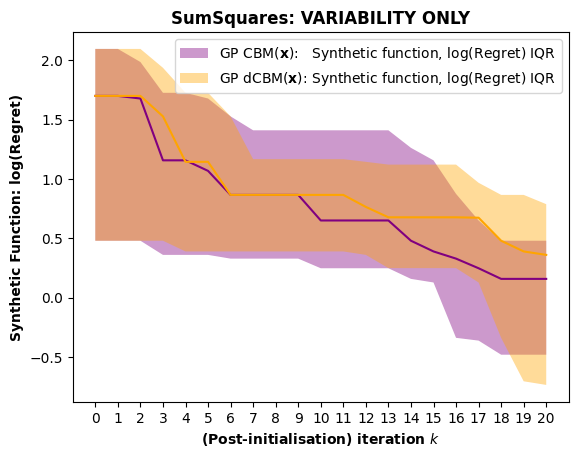

In [163]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP dCBM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


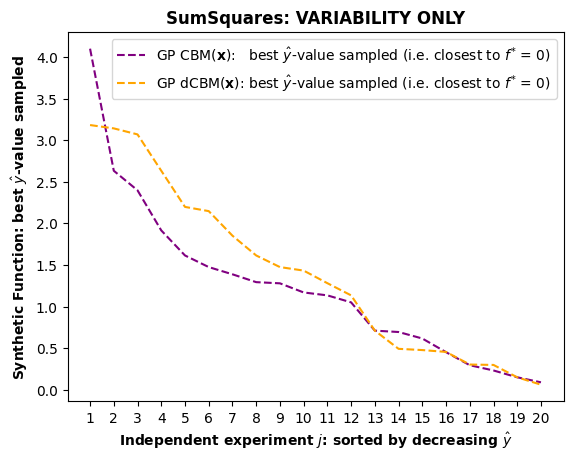

In [164]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Purple', ls='--', label='GP CBM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Orange', ls='--', label='GP dCBM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


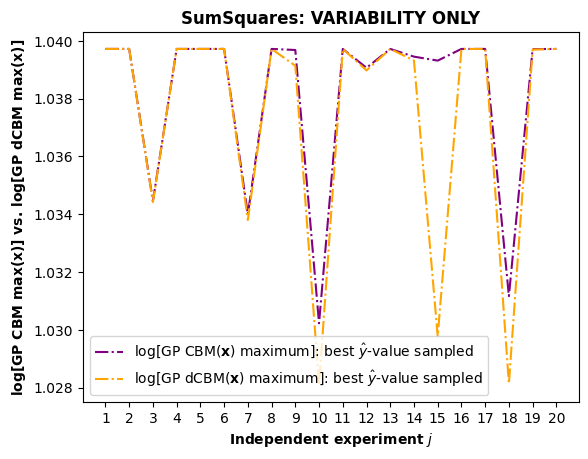

In [165]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Purple', ls='-.', label='log[GP CBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Orange', ls='-.', label='log[GP dCBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP CBM max($\mathbf{x}$)] vs. log[GP dCBM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


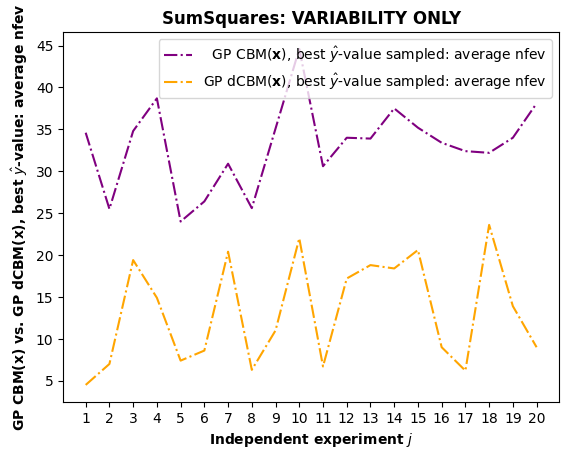

In [166]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


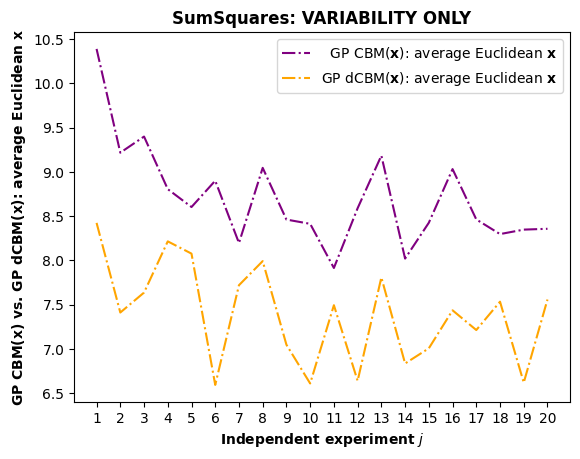

In [167]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([2.7084, 2.7532, 2.8046, 2.8063, 2.7955, 2.805 , 2.7988, 2.7967,
        2.788 , 2.8063, 2.8046, 2.7773, 2.8062, 2.8062, 2.7084, 2.8063,
        2.7967, 2.7266, 2.7958, 2.7084]),
 2.8063,
 array([0.77965702, 5.12      ]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([2.5942, 2.7658, 2.7107, 2.7208, 2.7124, 2.8004, 2.7757, 2.7727,
        2.7677, 2.805 , 2.753 , 2.6481, 2.5926, 2.7124, 2.7466, 2.6425,
        2.7819, 2.7178, 2.6995, 2.793 ]),
 2.805,
 array([0.90975019, 5.12      ]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.7807,  0.7569],
       [-5.12  , -2.5918],
       [-0.3853,  2.1524],
       [ 0.7796,  5.12  ],
       [-3.6586,  3.4661],
       [ 2.9734,  1.92  ],
       [ 3.3128,  3.1625],
       [ 3.6419, -3.7149],
       [-5.12  ,  0.6149],
       [ 0.7797,  5.12  ],
       [-0.3853,  2.1524],
       [ 0.3509, -3.8767],
       [-4.0721,  0.6599],
       [-4.0721,  0.6599],
       [-1.7807,  0.7569],
       [ 0.7797,  5.12  ],
       [ 3.6419, -3.7149],
       [ 4.4023, -1.0175],
       [ 0.9735, -1.1949],
       [-1.7807,  0.7569]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.5382, -0.4508],
       [-3.9367, -2.1887],
       [ 0.1168,  1.3588],
       [ 1.518 ,  4.621 ],
       [-1.8884,  3.229 ],
       [ 2.974 ,  2.4335],
       [ 3.0799,  3.5639],
       [ 3.5758, -2.9231],
       [-3.6336,  0.1914],
       [ 0.9098,  5.12  ],
       [-5.12  , -2.6131],
       [ 1.4114, -4.1211],
       [-1.5348, -0.3518],
       [-3.7752, -0.5133],
       [-5.12  , -5.12  ],
       [ 2.1965,  4.1652],
       [ 3.3189, -4.7041],
       [ 4.2215, -0.8904],
       [ 1.7368, -1.775 ],
       [-0.1685,  1.8829]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


6.852231659262613

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

13.72060363273114